# Candidate City Selection for Causal Inference

This notebook iterates over all cities as potential targets and identifies control cities that match the multi-layer robustness criteria from the causal impact analysis.

In [ ]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from causalimpact import CausalImpact
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Set visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Set up periods
pre_beg, pre_end = '2023-01-01', '2023-05-31'
post_beg, post_end = '2023-06-01', '2023-06-30'
pre_period = [pre_beg, pre_end]
post_period = [post_beg, post_end]

In [ ]:
def calculate_dtw_distance(s1, s2):
    """Shape-based similarity using Dynamic Time Warping."""
    from fastdtw import fastdtw
    distance, path = fastdtw(s1.fillna(0).values, s2.fillna(0).values, dist=lambda a, b: abs(a - b))
    return distance

def get_mutual_info(s1, s2):
    """Non-linear dependency detection."""
    from sklearn.feature_selection import mutual_info_regression
    mi = mutual_info_regression(s1.values.reshape(-1, 1), s2)
    return mi[0]

def get_stationary_transform(series, seasonal_period=7):
    """Returns (step_name, transform_func) or (None, None)."""
    from statsmodels.tsa.stattools import adfuller
    def is_stationary(s):
        try: return adfuller(s.dropna())[1] < 0.05
        except: return False
    if is_stationary(series): return "Raw", lambda s: s
    try:
        s_log = np.log(series)
        if is_stationary(s_log): return "Log", lambda s: np.log(s)
        s_diff = s_log.diff()
        if is_stationary(s_diff): return "Log+Diff", lambda s: np.log(s).diff()
        s_seasonal = s_diff.diff(seasonal_period)
        if is_stationary(s_seasonal): return "Log+Diff+Seasonal", lambda s: np.log(s).diff().diff(seasonal_period)
    except: pass
    return None, None

def select_best_controls(df_full, target, pre_beg, pre_end, t1_thresh=0.8, t2_thresh=0.6):
    """RANKING SYSTEM: Multi-metric selection using Correlation, DTW, Mutual Info, and Granger Causality."""
    import pandas as pd
    import numpy as np
    from statsmodels.tsa.stattools import grangercausalitytests
    df_pre = df_full.loc[pre_beg:pre_end]
    potential_controls = [c for c in df_full.columns if c != target]
    
    results = []
    for city in potential_controls:
        corr_raw = df_pre[target].corr(df_pre[city])
        step_name, transform_func = get_stationary_transform(df_pre[city])
        
        corr_trans, var_ratio, granger_p = 0, 0, 1.0
        
        if step_name:
            s_city_trans = transform_func(df_pre[city]).dropna()
            s_target_trans = transform_func(df_pre[target]).dropna()
            joined = pd.concat([s_city_trans, s_target_trans], axis=1).dropna()
            joined.columns = [city, target]
            corr_trans = joined.iloc[:, 0].corr(joined.iloc[:, 1])
            var_ratio = s_city_trans.std() / s_target_trans.std() if s_target_trans.std() != 0 else 0
            
            try:
                granger_result = grangercausalitytests(joined[[target, city]], maxlag=2, verbose=False)
                granger_p = granger_result[1][0]['params_ftest'][1]
            except: pass
        
        dtw_dist = calculate_dtw_distance(df_pre[target], df_pre[city])
        mi_score = get_mutual_info(df_pre[city], df_pre[target])
        
        tier = "None"
        if corr_trans > t1_thresh and 0.5 < var_ratio < 2.0:
            if granger_p < 0.05 or mi_score > 0.6:
                tier = "Tier 1 (Elite)"
            else:
                tier = "Tier 2 (Robust)"
        elif corr_raw > t2_thresh:
            tier = "Tier 3 (Baseline)"
            
        results.append({
            'City': city,
            'Corr_Transformed': corr_trans,
            'Variance_Ratio': var_ratio,
            'Granger_p': granger_p,
            'DTW_Distance': dtw_dist,
            'Mutual_Info': mi_score,
            'Selection_Tier': tier
        })
        
    matrix = pd.DataFrame(results).sort_values(['Selection_Tier', 'DTW_Distance'])
    selected = matrix[matrix['Selection_Tier'].isin(["Tier 1 (Elite)", "Tier 2 (Robust)"])]['City'].tolist()
    if not selected: selected = matrix[matrix['Selection_Tier'] == "Tier 3 (Baseline)"]['City'].tolist()
        
    return matrix, selected


In [ ]:
df_long = pd.read_csv('sales_data.csv')
df_long['Date'] = pd.to_datetime(df_long['Date'])

# Pivot the long format data back to wide format for analysis
df = df_long.pivot(index='Date', columns='City', values='Value')

print(f"Dataset loaded in LONG format and pivoted to WIDE. Total columns: {len(df.columns)}")
df.head()

df.index.freq = 'D'

Dataset loaded in LONG format and pivoted to WIDE. Total columns: 23


## Power Analysis & Volume Recommendations

In [ ]:
def run_power_simulation(df_full, target, controls, lift_percent, pre_period, post_period, num_sims=20):
    """Calculates statistical power for a given lift level via Monte Carlo."""
    data_base = df_full[[target] + controls].fillna(method='ffill').fillna(0)
    hits = 0
    for _ in range(num_sims):
        sim_data = data_base.copy()
        pre_mean = data_base.loc[pre_period[0]:pre_period[1], target].mean()
        sim_data.loc[post_period[0]:post_period[1], target] += pre_mean * (lift_percent / 100)
        try:
            ci = CausalImpact(sim_data, pre_period, post_period)
            if ci.p_value < 0.05: hits += 1
        except: pass
    return hits / num_sims

def analyze_power_and_volume(df_full, target, controls, pre_period, post_period):
    """Runs comprehensive power sweep and visualizes results."""
    lifts = [2, 5, 10, 15, 20]
    results = []
    print(f"--- Power Analysis for {target} ---")
    for lift in lifts:
        pwr = run_power_simulation(df_full, target, controls, lift, pre_period, post_period)
        results.append({'Lift_%': lift, 'Power': pwr})
        print(f"  Testing {lift}% lift -> Detection Probability: {pwr:.1%}")
    
    p_df = pd.DataFrame(results)
    
    # Visualization
    plt.figure(figsize=(10, 5))
    sns.barplot(data=p_df, x='Lift_%', y='Power', hue='Lift_%', palette='viridis', legend=False)
    plt.axhline(0.8, color='crimson', linestyle='--', label='80% Power Threshold')
    plt.title(f'Detection Power by Lift Magnitude: {target}', fontsize=14)
    plt.ylim(0, 1.1)
    plt.ylabel('Probability of Detection')
    plt.legend()
    plt.show()
    
    # Volume Recommendation
    mde_80 = p_df[p_df['Power'] >= 0.8]['Lift_%'].min()
    print(f"\nRECOMMENDATION: Minimum Detectable Effect (MDE) at 80% power is {mde_80}%.")
    return p_df


,City,Corr_Transformed,Variance_Ratio,Granger_p,DTW_Distance,Mutual_Info,Selection_Tier
9,City_18,0.846793,0.751994,6.377158e-12,1136.873046,0.711615,Tier 1 (Elite)
15,City_5,0.002337,1.031829,3.804227e-01,573.341353,0.542119,Tier 3 (Baseline)
12,City_20,0.017038,0.929923,5.564714e-02,573.391844,0.516016,Tier 3 (Baseline)
2,City_11,-0.050400,0.996616,1.913188e-01,594.681151,0.515066,Tier 3 (Baseline)
7,City_16,0.218296,1.091756,1.768180e-02,602.262323,0.642986,Tier 3 (Baseline)
11,City_2,-0.075044,0.225558,1.335630e-01,1013.378407,0.623704,Tier 3 (Baseline)
18,City_8,0.000000,0.000000,1.000000e+00,1043.829508,0.679896,Tier 3 (Baseline)
19,City_9,-0.156884,0.219510,3.271496e-01,1054.582421,0.661001,Tier 3 (Baseline)
5,City_14,0.000000,0.000000,1.000000e+00,1074.296751,0.623685,Tier 3 (Baseline)
10,City_19,0.049834,0.243736,2.147220e-01,1083.853897,0.673812,Tier 3 (Baseline)


--- Power Analysis for City_1 ---


  Testing 2% lift -> Detection Probability: 100.0%


  Testing 5% lift -> Detection Probability: 100.0%


  Testing 10% lift -> Detection Probability: 100.0%


  Testing 15% lift -> Detection Probability: 0.0%


  Testing 20% lift -> Detection Probability: 0.0%


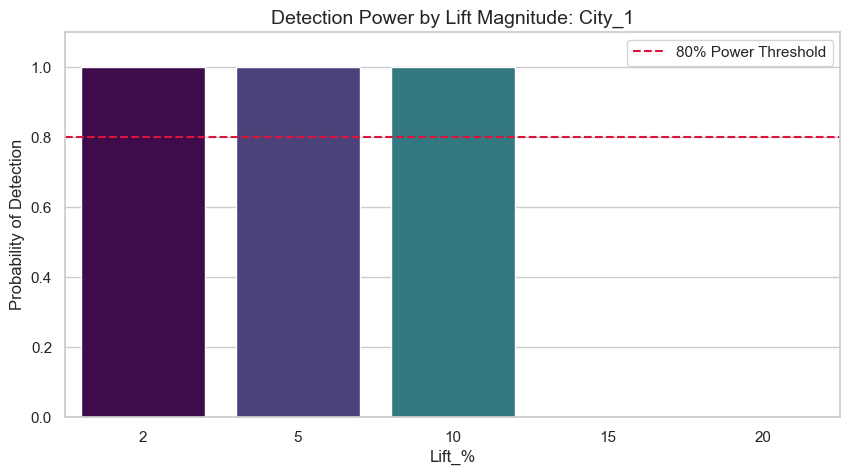


RECOMMENDATION: Minimum Detectable Effect (MDE) at 80% power is 2%.


In [ ]:
target_city = 'City_1'
matrix, selected = select_best_controls(df, target_city, pre_beg, pre_end)
display(matrix[matrix['Selection_Tier'] != 'None'].head(10))

if selected:
    analyze_power_and_volume(df, target_city, selected[:3], pre_period, post_period)
